In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/jupyter/checkmate-histo/consolidated_workflow/immunoprofile_analysis/')

from imports import *
import xarray
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
# import plotly.express as px

set_rc()

from skimage.io import imread
from deepcell.applications import Mesmer

qptiff_channels = ['dapi', 'foxp3', 'tumor_specific', 'cd8', 'pd1', 'pdl1','autofluorescence']

gating_cols = ['cd8_gate','tumor_gate']

morph_fts = [
    'centroid_dif', # asymmetry ??
    'num_concavities', # "concavities"
    'convex_hull_resid', # I think this is "Fill"
    'major_axis_equiv_diam_ratio', # "aspect ratio"
    'perim_square_over_area', # "perimeter to area ratio"
    'arcsinh_area',
]

gating_cols = ['tumor_gate','cd8_gate']

feature_cols = qptiff_channels + morph_fts

candidates = pd.read_csv('./immunoprofile_hne_rag_features__passing_14_subset.csv', index_col=0)

candidates = candidates.drop('IP_19_E00218')

### Load in data
- In `pilot_combined_proper_membrane_channels_mesmer`NB we did per-cell-type residual transformation of expression values (within each slide)

In [2]:
f_rerun = '/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/ccrcc_ip14_arcsinh_quant_agg_with_basic_cutoffs__rerun_correct_grade_seg__hybrid_manual_global_louvain__morph_flag__cellsubtypes.pkl'

In [3]:
data = pd.read_pickle(f_rerun)

In [4]:
data.shape

(16891101, 88)

In [5]:
def get_cd8(df, label_col='filtered_cell_type', label_key='filtered_cell_label_cd8+'):
    return df.loc[df[label_col] == label_key]

def get_tumor(df, label_col='filtered_cell_type', label_key='filtered_cell_label_tumor+'):
    return df.loc[df[label_col] == label_key]

### Derive FOXP3 positivity for various compartments

In [6]:
data['consolidated_cell_type'] = data['detailed_cell_type']

crit = data['consolidated_cell_type'].isin(['filtered_meta_other','unclear_intermediate'])
data.loc[crit, 'consolidated_cell_type'] = 'Ungated'

crit = data['consolidated_cell_type'].apply(lambda x: 'omit' in x)
data.loc[crit, 'consolidated_cell_type'] = 'Omit'

In [7]:
def get_ungated(df, label_col='consolidated_cell_type', label_key='Ungated'):
    return df.loc[df[label_col] == label_key]

In [8]:
subtype_cutoffs = {
    'residual_foxp3_in_ungated':np.nan,
    'residual_foxp3_in_cd+':np.nan,
    'residual_pd1_in_cd8+': np.nan,
    'residual_pdl1_in_tumor+':np.nan,
}

### FOXP3 in Ungated

IP_19_D00209
0.11946103517353884
IP_20_F00356
-0.0030157168715494453
IP_19_K00367
-0.021187529598652055
IP_19_F00568
0.3080309839892632
IP_20_J00195
-0.018343249701117184
IP_19_G00562
0.10546525422785956
IP_20_M00245
0.07186326597636464
IP_19_G00660
0.06802925028777396
IP_19_J00132
0.324842402303397
IP_19_K00058
0.1815828425491868
IP_18_A00093
-0.15862236595325796
IP_19_R00053
0.48550913760878855
IP_19_T00810
-0.022562690095032256


(-1.5, 1.5)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


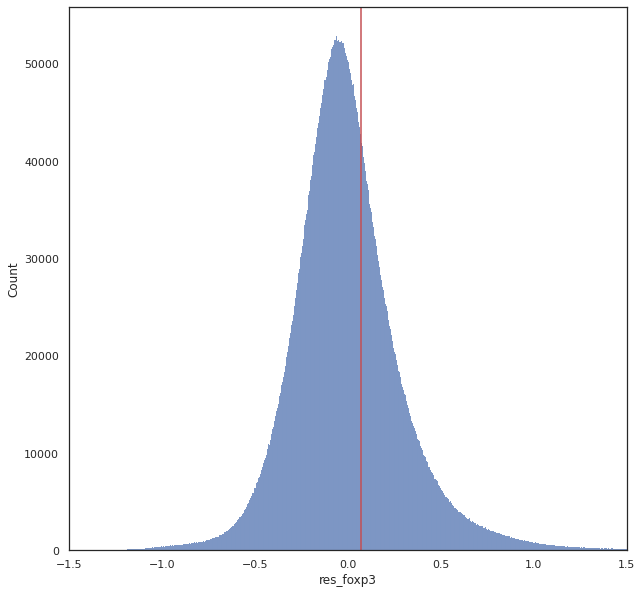

In [9]:
subset = data.loc[data['consolidated_cell_type'] == 'Ungated']

marker = 'foxp3'
cutoffs = []
for case_id in candidates.index.values:
    print(case_id)
    tmp = subset.loc[case_id]
    tmp = tmp.loc[tmp['meta'] == 'Tumor (H&E)']
    
    lb = tmp[f'res_{marker}'].quantile(0.001)
    ub = tmp[f'res_{marker}'].quantile(0.999)

    crit = (tmp[f'res_{marker}'] < ub) & (tmp[f'res_{marker}'] > lb)
    tmp = tmp.loc[crit]
    
    a = run_gating_flex(tmp, f'res_{marker}', 2)
    
    a = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.05).max()
    b = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.95).min()

    cut = np.mean([a,b])
    print(cut)
    
    cutoffs.append(cut)
    
    # set_rc(5,5)
    # sns.histplot(x=f'res_{marker}', data=tmp.reset_index())
    # plt.axvline(cut, c='r')
    # plt.show()
cutoff_summary = pd.Series(cutoffs).describe()

subtype_cutoffs['residual_foxp3_in_ungated'] = cutoff_summary['50%']

sns.histplot(x=f'res_{marker}', data=subset.reset_index())
plt.axvline(subtype_cutoffs['residual_foxp3_in_ungated'], c='r')
plt.xlim(-1.5,1.5)

### FOXP3 in CD8+

IP_19_D00209
0.11371609844527547
IP_20_F00356
-0.021590299474735675
IP_19_K00367
0.02590071916137253
IP_19_F00568
0.11810585076340308
IP_20_J00195
0.040212310058591695
IP_19_G00562
0.0024122248099213784
IP_20_M00245
0.14571288339962732
IP_19_G00660
0.3285641707427238
IP_19_J00132
0.37135479251250914
IP_19_K00058
0.15488494023823915
IP_18_A00093
-0.08910536607800679
IP_19_R00053
0.1948413685601672
IP_19_T00810
0.022991806852873546


(-1.5, 1.5)

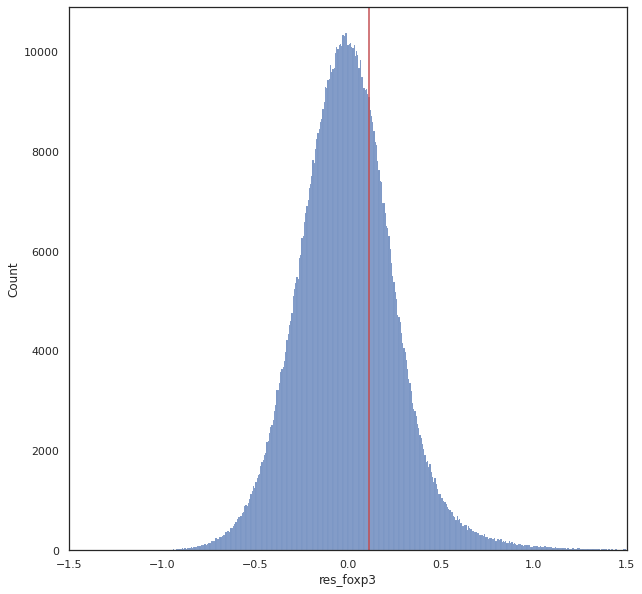

In [10]:
subset = data.loc[data['filtered_cell_type'] == 'filtered_cell_label_cd8+']

marker = 'foxp3'
cutoffs = []
for case_id in candidates.index.values:
    print(case_id)
    tmp = subset.loc[case_id]
    tmp = tmp.loc[tmp['meta'] == 'Tumor (H&E)']
    
    lb = tmp[f'res_{marker}'].quantile(0.001)
    ub = tmp[f'res_{marker}'].quantile(0.999)

    crit = (tmp[f'res_{marker}'] < ub) & (tmp[f'res_{marker}'] > lb)
    tmp = tmp.loc[crit]
    
    a = run_gating_flex(tmp, f'res_{marker}', 2)
    
    a = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.05).max()
    b = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.95).min()

    cut = np.mean([a,b])
    print(cut)
    
    cutoffs.append(cut)
    # sns.histplot(x=f'res_{marker}', data=tmp.reset_index())
    # plt.axvline(cut, c='r')
    # plt.show()
cutoff_summary = pd.Series(cutoffs).describe()

subtype_cutoffs['residual_foxp3_in_cd8+'] = cutoff_summary['50%']


sns.histplot(x=f'res_{marker}', data=subset.reset_index())
plt.axvline(subtype_cutoffs['residual_foxp3_in_cd8+'], c='r')
plt.xlim(-1.5,1.5)

### FOXP3 in Tumor+

IP_19_D00209
0.0972279464253383
IP_20_F00356
-0.005929033952955319
IP_19_K00367
0.10000571440038554
IP_19_F00568
0.1099679300279455
IP_20_J00195
-0.00690915685492316
IP_19_G00562
0.15529596997140768
IP_20_M00245
0.11390180756236015
IP_19_G00660
0.089135599955673
IP_19_J00132
-0.02420766714594198
IP_19_K00058
-0.117669564038043
IP_18_A00093
-0.09603007713010321
IP_19_R00053
0.050775365534639884
IP_19_T00810
0.06602564626936969


(-1.5, 1.5)

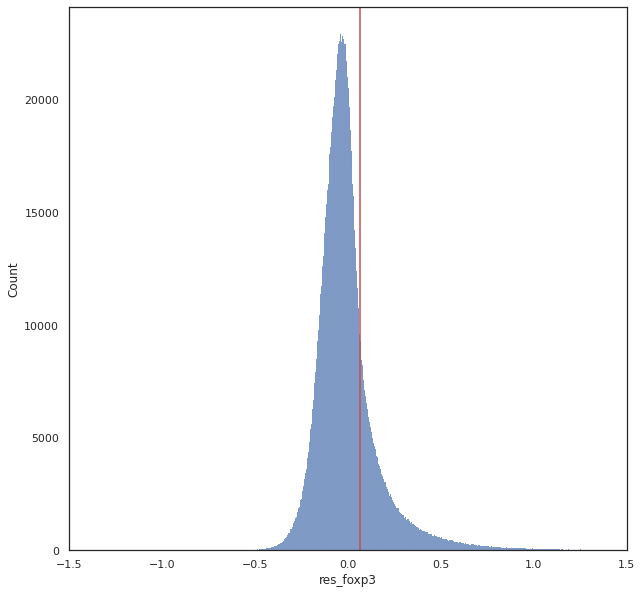

In [11]:
subset = data.loc[data['filtered_cell_type'] == 'filtered_cell_label_tumor+']

marker = 'foxp3'
cutoffs = []
for case_id in candidates.index.values:
    print(case_id)
    tmp = subset.loc[case_id]
    tmp = tmp.loc[tmp['meta'] == 'Tumor (H&E)']
    
    lb = tmp[f'res_{marker}'].quantile(0.001)
    ub = tmp[f'res_{marker}'].quantile(0.999)

    crit = (tmp[f'res_{marker}'] < ub) & (tmp[f'res_{marker}'] > lb)
    tmp = tmp.loc[crit]
    
    a = run_gating_flex(tmp, f'res_{marker}', 2)
    
    a = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.05).max()
    b = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.95).min()

    cut = np.mean([a,b])
    print(cut)
    
    cutoffs.append(cut)
    # sns.histplot(x=f'res_{marker}', data=tmp.reset_index())
    # plt.axvline(cut, c='r')
    # plt.show()
cutoff_summary = pd.Series(cutoffs).describe()

subtype_cutoffs['residual_foxp3_in_tumor+'] = cutoff_summary['50%']


sns.histplot(x=f'res_{marker}', data=subset.reset_index())
plt.axvline(subtype_cutoffs['residual_foxp3_in_tumor+'], c='r')
plt.xlim(-1.5,1.5)

### PD1 in CD8+ [Rerun]

IP_19_D00209
0.2006729788510757
IP_20_F00356
0.11541192885053295
IP_19_K00367
0.0008438474175525464
IP_19_F00568
0.19182752241613307
IP_20_J00195
0.2552833532233514
IP_19_G00562
0.17910888777379652
IP_20_M00245
0.2278589645841565
IP_19_G00660
0.22349099064698175
IP_19_J00132
0.29252848206029847
IP_19_K00058
0.30856252256456607
IP_18_A00093
0.6420423226641134
IP_19_R00053
0.1767337663448319
IP_19_T00810
0.25332855309332813


(-1.5, 1.5)

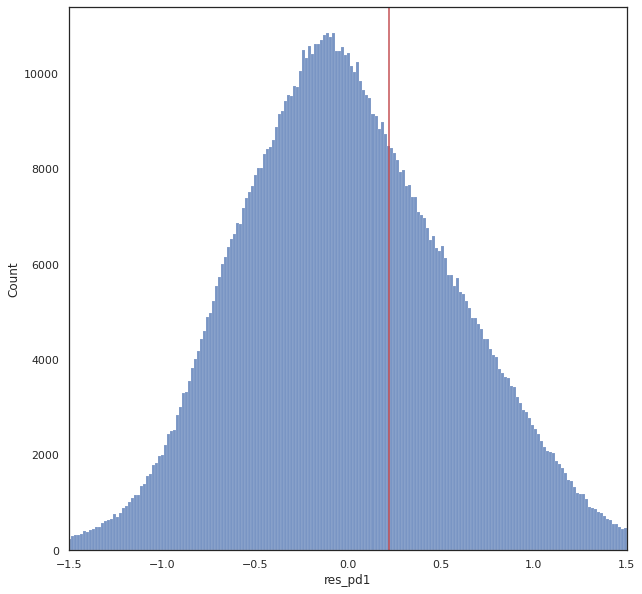

In [12]:
subset = data.loc[data['filtered_cell_type'] == 'filtered_cell_label_cd8+']

marker = 'pd1'
cutoffs = []
for case_id in candidates.index.values:
    print(case_id)
    tmp = subset.loc[case_id]
    tmp = tmp.loc[tmp['meta'] == 'Tumor (H&E)']
    
    lb = tmp[f'res_{marker}'].quantile(0.001)
    ub = tmp[f'res_{marker}'].quantile(0.999)

    crit = (tmp[f'res_{marker}'] < ub) & (tmp[f'res_{marker}'] > lb)
    tmp = tmp.loc[crit]
    
    a = run_gating_flex(tmp, f'res_{marker}', 2)
    
    a = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.05).max()
    b = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.95).min()

    cut = np.mean([a,b])
    print(cut)
    
    cutoffs.append(cut)
    
    # set_rc(5,5)
    # sns.histplot(x=f'res_{marker}', data=tmp.reset_index())
    # plt.axvline(cut, c='r')
    # plt.show()
cutoff_summary = pd.Series(cutoffs).describe()

subtype_cutoffs['residual_pd1_in_cd8+'] = cutoff_summary['50%']

sns.histplot(x=f'res_{marker}', data=subset.reset_index())
plt.axvline(subtype_cutoffs['residual_pd1_in_cd8+'], c='r')
plt.xlim(-1.5,1.5)

### Re-run Tumor+ PDL Residual Cutoff using overlapping quantile approach 


IP_19_D00209
0.15753608195083083
IP_20_F00356
0.10962236669422351
IP_19_K00367
0.014817110674620925
IP_19_F00568
0.15729188914744863
IP_20_J00195
0.08003975177172418
IP_19_G00562
0.33994131036730224
IP_20_M00245
0.15902256818078786
IP_19_G00660
0.09974712923464935
IP_19_J00132
-0.027024079907252765
IP_19_K00058
-0.06541745963401704
IP_18_A00093
-0.05863807228953109
IP_19_R00053
-0.025208465229605848
IP_19_T00810
0.1069723430371807


(-1.5, 1.5)

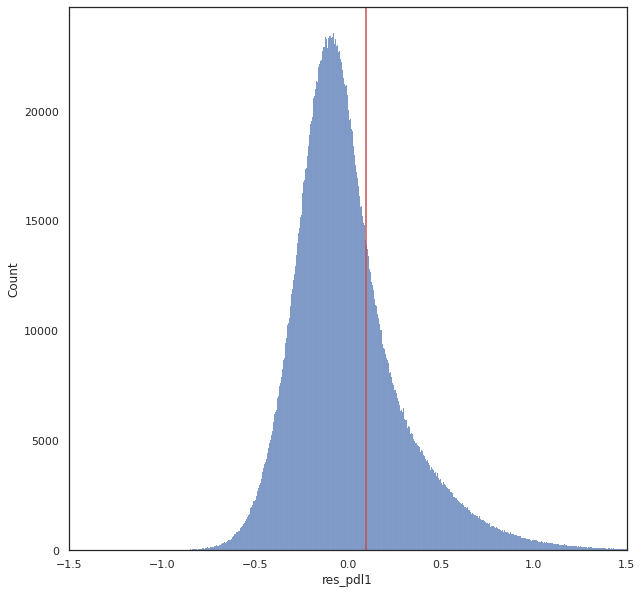

In [13]:
subset = data.loc[data['filtered_cell_type'] == 'filtered_cell_label_tumor+']

marker = 'pdl1'
cutoffs = []
for case_id in candidates.index.values:
    print(case_id)
    tmp = subset.loc[case_id]
    tmp = tmp.loc[tmp['meta'] == 'Tumor (H&E)']
    
    lb = tmp[f'res_{marker}'].quantile(0.001)
    ub = tmp[f'res_{marker}'].quantile(0.999)

    crit = (tmp[f'res_{marker}'] < ub) & (tmp[f'res_{marker}'] > lb)
    tmp = tmp.loc[crit]
    
    a = run_gating_flex(tmp, f'res_{marker}', 2)
    
    a = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.05).max()
    b = tmp.groupby(f'gmm_res_{marker}')[f'res_{marker}'].quantile(0.95).min()

    cut = np.mean([a,b])
    print(cut)
    
    cutoffs.append(cut)
    
    # set_rc(5,5)
    # sns.histplot(x=f'res_{marker}', data=tmp.reset_index())
    # plt.axvline(cut, c='r')
    # plt.show()
    
cutoff_summary = pd.Series(cutoffs).describe()

subtype_cutoffs['residual_pdl1_in_tumor+'] = cutoff_summary['50%']

sns.histplot(x=f'res_{marker}', data=subset.reset_index())
plt.axvline(subtype_cutoffs['residual_pdl1_in_tumor+'], c='r')
plt.xlim(-1.5,1.5)

In [14]:
subtype_cutoffs

{'residual_foxp3_in_ungated': 0.07186326597636464,
 'residual_foxp3_in_cd+': nan,
 'residual_pd1_in_cd8+': 0.22349099064698175,
 'residual_pdl1_in_tumor+': 0.09974712923464935,
 'residual_foxp3_in_cd8+': 0.11371609844527547,
 'residual_foxp3_in_tumor+': 0.06602564626936969}

In [15]:
data['filtered_cell_type'].unique()

array(['cd8-af-ratio_omit', 'filtered_cell_label_cd8+',
       'filtered_cell_label_tumor+', 'filtered_meta_other',
       'morphology_omit', 'unclear_intermediate', 'dapi_omit'],
      dtype=object)

In [16]:
data['detailed_cell_type'] = data['filtered_cell_type']

##### CD8+
crit = (data['filtered_cell_type'] == 'filtered_cell_label_cd8+') & (data['res_pd1'] >= subtype_cutoffs['residual_pd1_in_cd8+'])
data.loc[crit, 'detailed_cell_type'] = 'CD8+ PD1 High'

crit = (data['filtered_cell_type'] == 'filtered_cell_label_cd8+') & (data['res_pd1'] < subtype_cutoffs['residual_pd1_in_cd8+'])
data.loc[crit, 'detailed_cell_type'] = 'CD8+ PD1 Low'

##### Tumor+
crit = (data['filtered_cell_type'] == 'filtered_cell_label_tumor+') & (data['res_pdl1'] >= subtype_cutoffs['residual_pdl1_in_tumor+'])
data.loc[crit, 'detailed_cell_type'] = 'Tumor+ PDL1 High'

crit = (data['filtered_cell_type'] == 'filtered_cell_label_tumor+') & (data['res_pdl1'] < subtype_cutoffs['residual_pdl1_in_tumor+'])
data.loc[crit, 'detailed_cell_type'] = 'Tumor+ PDL1 Low'

##### Ungated
crit = (data['consolidated_cell_type'] == 'Ungated') & (data['res_pdl1'] >= subtype_cutoffs['residual_foxp3_in_ungated'])
data.loc[crit, 'detailed_cell_type'] = 'Ungated+ FOXP3 High'

crit = (data['consolidated_cell_type'] == 'Ungated') & (data['res_pdl1'] < subtype_cutoffs['residual_foxp3_in_ungated'])
data.loc[crit, 'detailed_cell_type'] = 'Ungated+ FOXP3 Low'

##### Omit
crit = data['detailed_cell_type'].apply(lambda x: 'omit' in x)
data.loc[crit, 'detailed_cell_type'] = 'Omit'

In [17]:
data['detailed_cell_type'].value_counts()

Ungated+ FOXP3 Low     6342667
Ungated+ FOXP3 High    3546917
Omit                   3295743
Tumor+ PDL1 Low        1992816
Tumor+ PDL1 High        789751
CD8+ PD1 Low            614817
CD8+ PD1 High           308390
Name: detailed_cell_type, dtype: int64

In [18]:
f_rerun

'/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/ccrcc_ip14_arcsinh_quant_agg_with_basic_cutoffs__rerun_correct_grade_seg__hybrid_manual_global_louvain__morph_flag__cellsubtypes.pkl'

In [19]:
f_calls = '/mnt/disks/image_data/immunoprofile/ccrcc_subset_processing/ccrcc_ip14_arcsinh_quant_agg__hybrid_detailed_cell_type_calls.pkl'

In [20]:
data.to_pickle(f_calls)